Import Library

In [16]:
# Import library
from google.colab import drive
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pickle

Load Dataset

Mounted at /content/drive
Jumlah Gambar AI   : 400
Jumlah Gambar Real : 400
Total Gambar       : 800


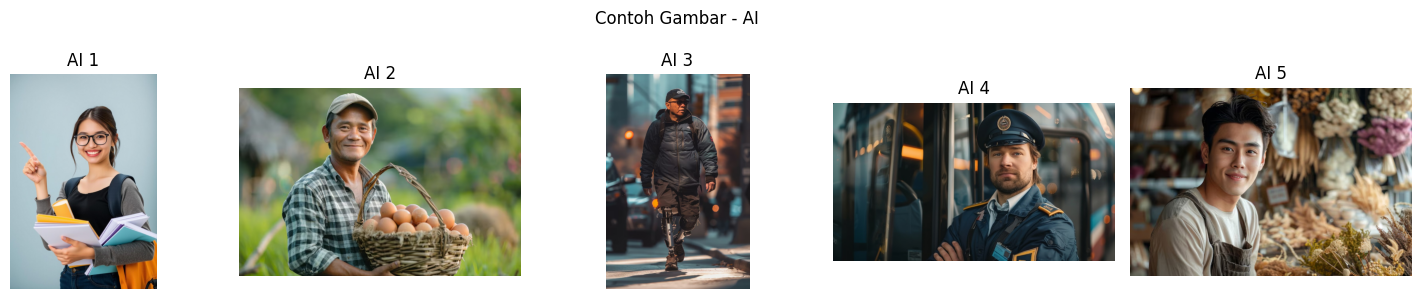

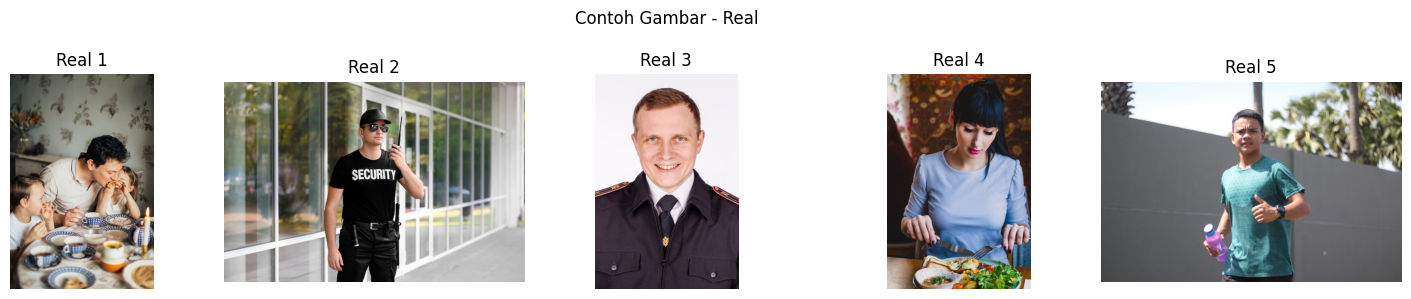

In [2]:
# 1. Fungsi untuk Mount Google Drive dan Mengatur Path Dataset
def mount_drive_and_load_paths():
    drive.mount('/content/drive')

    # Tentukan base path folder dataset
    base_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI')

    # Kembalikan path ke folder AI dan Real
    return base_path / 'AI Image', base_path / 'Real Image'

# 2. Fungsi untuk Mengambil Semua Path Gambar
def load_image_paths(ai_path, real_path):
    # Ambil semua path gambar AI dan urutkan
    ai_images = sorted(glob(str(ai_path / '*')))

    # Ambil semua path gambar Real dan urutkan
    real_images = sorted(glob(str(real_path / '*')))

    return ai_images, real_images

# 3. Fungsi untuk Menampilkan Informasi Jumlah Dataset
def show_dataset_info(ai_images, real_images):
    print(f"Jumlah Gambar AI   : {len(ai_images)}")
    print(f"Jumlah Gambar Real : {len(real_images)}")
    print(f"Total Gambar       : {len(ai_images) + len(real_images)}")

# 4. Fungsi untuk Menampilkan Contoh Gambar dari Setiap Kelas
def plot_example_images(image_paths, title):
    plt.figure(figsize=(15, 3))

    # Tampilkan 5 contoh gambar pertama dari daftar image_paths
    for i, path in enumerate(image_paths[:5]):
        img = cv2.imread(path)

        # Lewati jika gambar tidak bisa dibaca
        if img is None:
            continue

        # Konversi BGR ke RGB agar warna tidak terbalik
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot gambar
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i + 1}')
        plt.axis('off')

    # Judul utama untuk semua subplot
    plt.suptitle(f'Contoh Gambar - {title}')
    plt.tight_layout()
    plt.show()

# 5. Pemanggilan Semua Fungsi Utama

# Mount Google Drive dan ambil path ke folder AI & Real
ai_path, real_path = mount_drive_and_load_paths()

# Ambil semua path gambar dari kedua kelas
ai_images, real_images = load_image_paths(ai_path, real_path)

# Tampilkan informasi jumlah dataset
show_dataset_info(ai_images, real_images)

# Tampilkan contoh gambar untuk kelas AI
plot_example_images(ai_images, "AI")

# Tampilkan contoh gambar untuk kelas Real
plot_example_images(real_images, "Real")


In [3]:
# Gabungkan path gambar
image_paths = ai_images + real_images

# Label: AI = 0, Real = 1
labels = [0] * len(ai_images) + [1] * len(real_images)


X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Total Train 2 Kelas :", len(X_train))
print("Total Test 2 Kelas  :", len(X_test))


Total Train 2 Kelas : 640
Total Test 2 Kelas  : 160


Augmentasi

In [4]:
augmented_base_path = Path(
    '/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented'
)

(augmented_base_path / 'AI').mkdir(parents=True, exist_ok=True)
(augmented_base_path / 'Real').mkdir(parents=True, exist_ok=True)

def apply_augmentation(image_path, save_folder):
    img = cv2.imread(image_path)
    if img is None:
        return

    filename = Path(image_path).stem

    # Original
    cv2.imwrite(str(save_folder / f"{filename}_orig.jpg"), img)

    # Flip Horizontal
    flip_img = cv2.flip(img, 1)
    cv2.imwrite(str(save_folder / f"{filename}_flip.jpg"), flip_img)

    # Rotasi 10 derajat
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rot_img = cv2.warpAffine(
        img, M, (w, h), borderMode=cv2.BORDER_REFLECT
    )
    cv2.imwrite(str(save_folder / f"{filename}_rot.jpg"), rot_img)

    # Zoom
    zoom_factor = 0.85
    h_start, w_start = int(h * (1-zoom_factor)/2), int(w * (1-zoom_factor)/2)
    h_end, w_end = h - h_start, w - w_start
    zoom_img = img[h_start:h_end, w_start:w_end]
    zoom_img = cv2.resize(zoom_img, (w, h))
    cv2.imwrite(str(save_folder / f"{filename}_zoom.jpg"), zoom_img)
print("Sedang memproses augmentasi data TRAIN saja...")

for path, label in zip(X_train, y_train):
    if label == 0:
        save_folder = augmented_base_path / 'AI'
    else:
        save_folder = augmented_base_path / 'Real'

    apply_augmentation(path, save_folder)

print("Augmentasi data TRAIN selesai.")


Sedang memproses augmentasi data TRAIN saja...
Augmentasi data TRAIN selesai.


Jumlah Gambar AI   : 1280
Jumlah Gambar Real : 1280
Total Gambar       : 2560
--- Visualisasi Augmentasi Kelas: AI ---


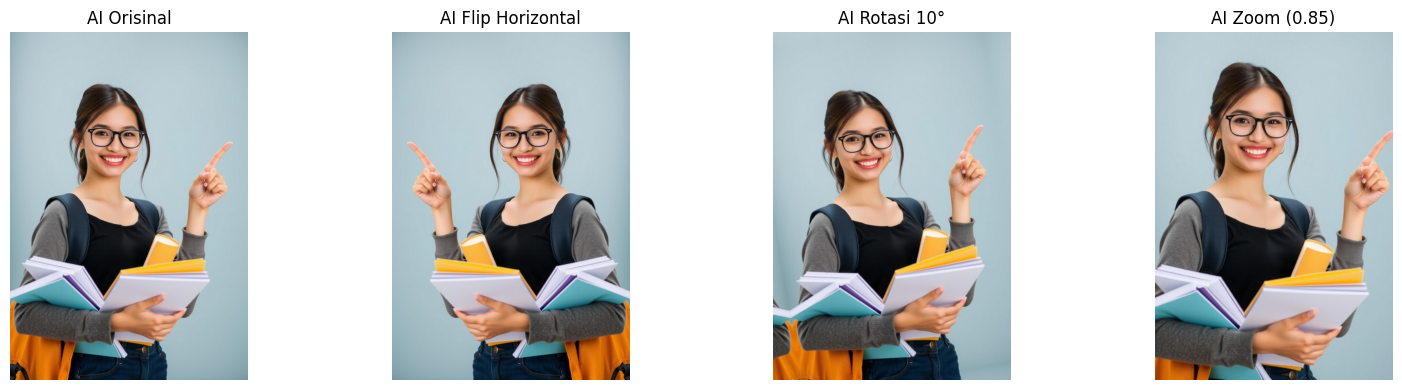



--- Visualisasi Augmentasi Kelas: REAL ---


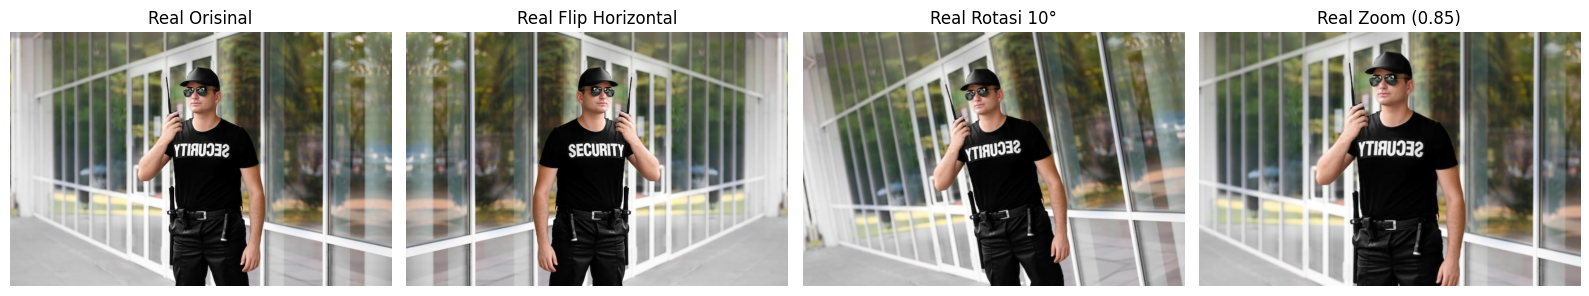

In [5]:
augmented_ai_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/AI')
augmented_real_path = Path('/content/drive/MyDrive/Klasifikasi Gambar Nyata atau AI/Dataset_Augmented/Real')

ai_images = sorted(glob(str(augmented_ai_path / '*.jpg')))
real_images = sorted(glob(str(augmented_real_path / '*.jpg')))

print(f"Jumlah Gambar AI   : {len(ai_images)}")
print(f"Jumlah Gambar Real : {len(real_images)}")
print(f"Total Gambar       : {len(ai_images) + len(real_images)}")

def plot_augmentation_examples(image_path, title_prefix):
    # 1. Load Gambar
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Gagal membaca gambar: {image_path}")
        return

    # Konversi ke RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Proses Augmentasi (Logika yang sama dengan Streamlit)
    # Flip
    flip = cv2.flip(img_rgb, 1)

    # Rotasi 10 Derajat
    (h, w) = img_rgb.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rot = cv2.warpAffine(img_rgb, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Zoom
    zf = 0.85
    hs, ws = int(h * (1-zf)/2), int(w * (1-zf)/2)
    zoom_crop = img_rgb[hs:h-hs, ws:w-ws]
    zoom = cv2.resize(zoom_crop, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3. Visualisasi dengan Matplotlib
    images = [img_rgb, flip, rot, zoom]
    titles = ["Orisinal", "Flip Horizontal", "Rotasi 10°", "Zoom (0.85)"]

    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"{title_prefix} {titles[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan contoh untuk Gambar AI
if len(ai_images) > 0:
    print("--- Visualisasi Augmentasi Kelas: AI ---")
    plot_augmentation_examples(ai_images[0], "AI")

print("\n") # Memberi jarak

# Menampilkan contoh untuk Gambar Real
if len(real_images) > 0:
    print("--- Visualisasi Augmentasi Kelas: REAL ---")
    plot_augmentation_examples(real_images[0], "Real")

Pra-pemrosesan Gambar

Memproses data training...
Memproses data testing...


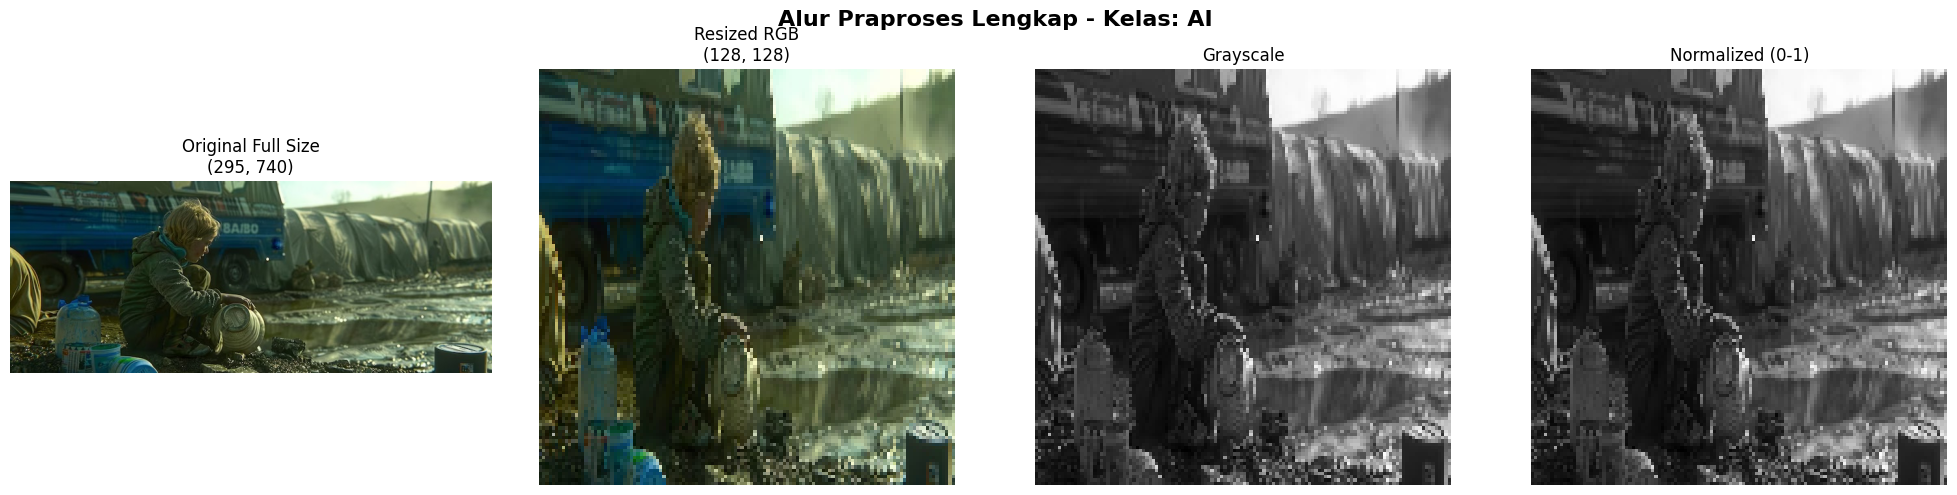

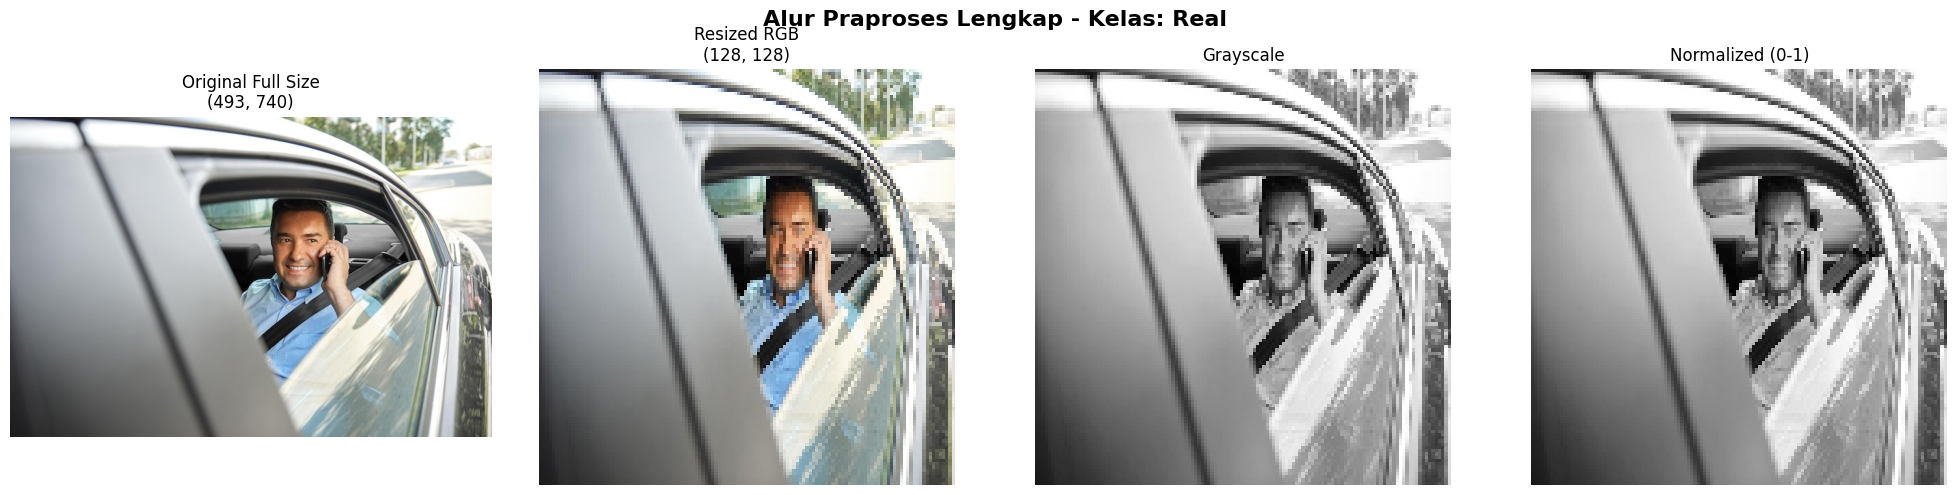

In [6]:
# 1. Fungsi Preprocessing (Sudah Benar)
def preprocess_image(image_path, size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_normalized = img_gray.astype(np.float32) / 255.0

    return img_normalized, img_rgb

# 2. Inisialisasi List
X_train_gray = []
X_train_rgb  = []
y_train_new  = []

# 3. Proses Data Training (Hasil Augmentasi)
print("Memproses data training...")
for label_folder, label in [('AI', 0), ('Real', 1)]:
    folder = augmented_base_path / label_folder
    # Ambil semua file jpg
    files = list(folder.glob("*.jpg"))
    for img_path in files:
        gray, rgb = preprocess_image(str(img_path))
        if gray is not None:
            X_train_gray.append(gray)
            X_train_rgb.append(rgb)
            y_train_new.append(label)

# 4. Proses Data Testing (Data Original)
X_test_gray = []
X_test_rgb  = []
y_test_new  = []

print("Memproses data testing...")
for path, label in zip(X_test, y_test):
    gray, rgb = preprocess_image(path)
    if gray is not None:
        X_test_gray.append(gray)
        X_test_rgb.append(rgb)
        y_test_new.append(label)

# 1. Cari path asli untuk contoh visualisasi
# Kita cari path pertama dari masing-masing kelas di folder augmented
path_contoh_ai = next(iter((augmented_base_path / 'AI').glob("*.jpg")), None)
path_contoh_real = next(iter((augmented_base_path / 'Real').glob("*.jpg")), None)

# 2. Fungsi Visualisasi dengan Gambar Asli (Full Size)
def show_full_preprocessing_with_original(image_path, label_name):
    # Load Gambar Asli (Buka dari path)
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        print(f"Gagal membaca gambar di: {image_path}")
        return

    img_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Proses langkah-langkah seperti di fungsi preprocess sebelumnya
    size = (128, 128)
    img_resized = cv2.resize(img_original, size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    img_normalized = img_gray.astype(np.float32) / 255.0

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Original
    axs[0].imshow(img_original)
    axs[0].set_title(f"Original Full Size\n{img_original.shape[:2]}")

    # 2. Resized
    axs[1].imshow(img_resized)
    axs[1].set_title(f"Resized RGB\n{size}")

    # 3. Grayscale
    axs[2].imshow(img_gray, cmap='gray')
    axs[2].set_title("Grayscale")

    # 4. Normalized
    axs[3].imshow(img_normalized, cmap='gray')
    axs[3].set_title("Normalized (0-1)")

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"Alur Praproses Lengkap - Kelas: {label_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 3. Eksekusi Tampilkan Hasil
if path_contoh_ai:
    show_full_preprocessing_with_original(path_contoh_ai, "AI")

if path_contoh_real:
    show_full_preprocessing_with_original(path_contoh_real, "Real")

Ekstraksi Fitur

HOG

HOG TRAIN shape: (2560, 8100)
HOG TEST  shape: (160, 8100)


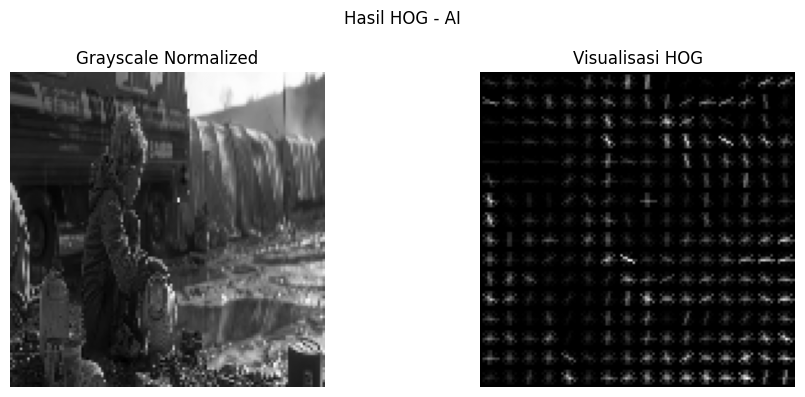

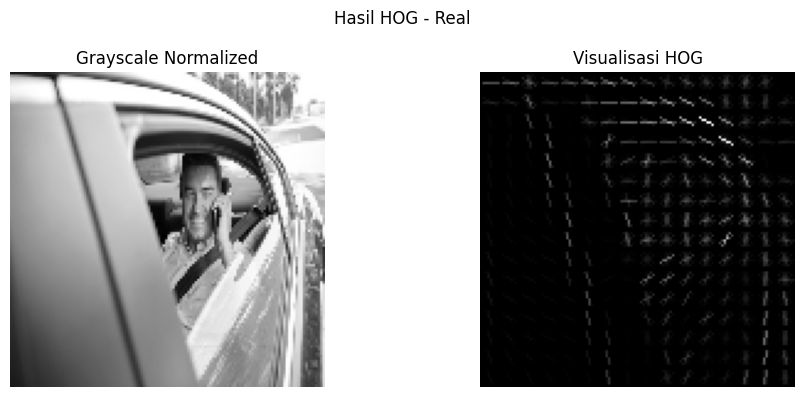


VEKTOR HOG - AI
Panjang vektor: 8100
20 nilai pertama:
[0.06535827 0.         0.01798657 0.03470334 0.24510624 0.30194598
 0.07976573 0.09688908 0.032743   0.29560462 0.04420795 0.04351821
 0.07933041 0.2742892  0.13479282 0.17143333 0.19747213 0.12828813
 0.00097546 0.00218119]

VEKTOR HOG - Real
Panjang vektor: 8100
20 nilai pertama:
[0.00334232 0.00200848 0.00988641 0.04997597 0.43799326 0.01098942
 0.01006318 0.         0.         0.01559749 0.         0.
 0.00373683 0.43799326 0.43799326 0.03746457 0.00356688 0.00176156
 0.02041714 0.0044997 ]


In [7]:
def extract_hog(images):
    features = []
    for img in images:
        feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=False
        )
        features.append(feat)
    return np.array(features)
# TRAIN
X_train_hog = extract_hog(X_train_gray)
y_train_hog = np.array(y_train_new)

# TEST
X_test_hog = extract_hog(X_test_gray)
y_test_hog = np.array(y_test_new)

print("HOG TRAIN shape:", X_train_hog.shape)
print("HOG TEST  shape:", X_test_hog.shape)
def show_hog_example(image_gray, label_name):
    _, hog_image = hog(
        image_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(image_gray, cmap='gray')
    axs[0].set_title("Grayscale Normalized")

    axs[1].imshow(hog_image, cmap='gray')
    axs[1].set_title("Visualisasi HOG")

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"Hasil HOG - {label_name}")
    plt.tight_layout()
    plt.show()
class_names = ["AI", "Real"]
class_mapping = {"AI": 0, "Real": 1}

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx = np.where(y_train_hog == label_val)[0]

    if len(idx) == 0:
        continue

    show_hog_example(X_train_gray[idx[0]], class_name)
for class_name in class_names:
    label_val = class_mapping[class_name]
    idx = np.where(y_train_hog == label_val)[0]

    if len(idx) == 0:
        continue

    vec = X_train_hog[idx[0]]
    print("\n" + "="*50)
    print(f"VEKTOR HOG - {class_name}")
    print("="*50)
    print("Panjang vektor:", len(vec))
    print("20 nilai pertama:")
    print(vec[:20])


Histogram RGB

Histogram RGB TRAIN: (2560, 96)
Histogram RGB TEST : (160, 96)


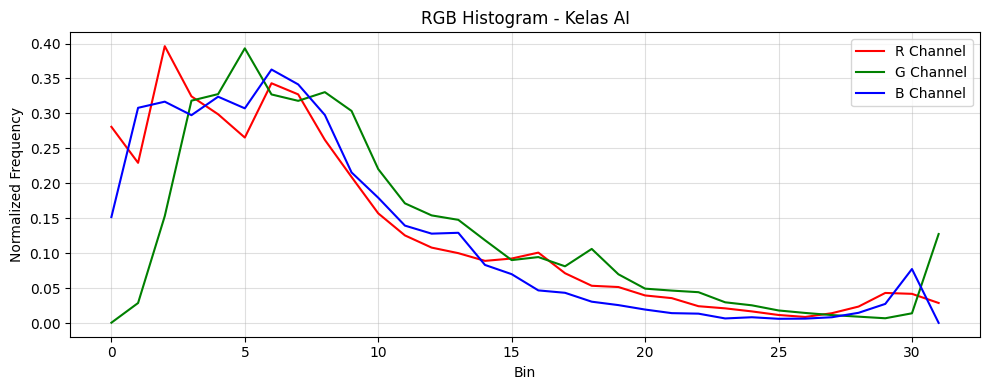

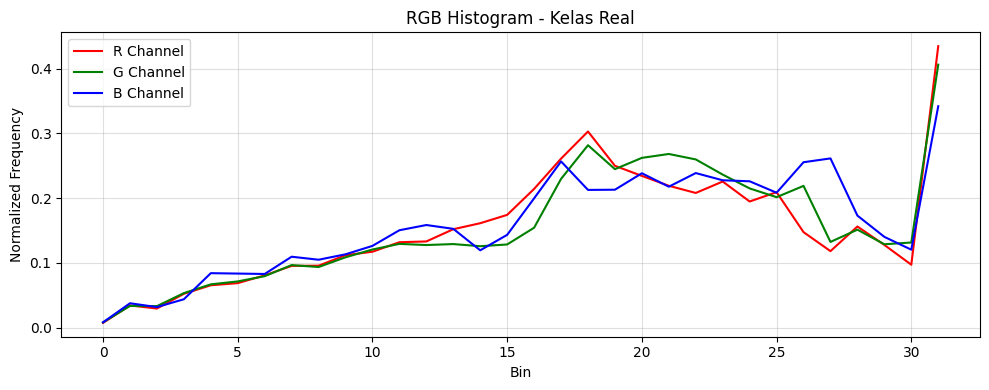


VEKTOR HISTOGRAM RGB - AI
Panjang vektor: 96
Vektor Fitur Numerik:
[0.28086808 0.22935852 0.39618802 0.3244334  0.29880676 0.2654921
 0.34314084 0.32725233 0.26216063 0.20911346 0.15709136 0.12557058
 0.10814446 0.10020021 0.08918075 0.09251221 0.100969   0.07149836
 0.0535597  0.05176583 0.03972131 0.03587731 0.02434532 0.02127012
 0.01691359 0.01178826 0.00896933 0.01435092 0.02383278 0.04330904
 0.04202771 0.02895812 0.0007608  0.02891056 0.15317525 0.31826976
 0.32765302 0.39308217 0.3271458  0.31801617 0.33044264 0.30356088
 0.22037962 0.17143455 0.15418966 0.14784962 0.11868546 0.0902821
 0.09459332 0.08140605 0.10625899 0.06999399 0.04945228 0.04666266
 0.04438025 0.02992497 0.02561374 0.0182593  0.01470888 0.01166566
 0.00938325 0.00710084 0.01420168 0.12756151 0.15181108 0.30802247
 0.31682312 0.2975106  0.32391253 0.3072891  0.36278203 0.3415138
 0.29775506 0.21561573 0.17943531 0.13958797 0.12809823 0.12932055
 0.08336164 0.07016067 0.04693676 0.04351429 0.03080225 0.025913

In [8]:
def extract_rgb_histogram(images, bins=32):
    features = []

    for img in images:
        hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256])

        hist_r = cv2.normalize(hist_r, hist_r).flatten()
        hist_g = cv2.normalize(hist_g, hist_g).flatten()
        hist_b = cv2.normalize(hist_b, hist_b).flatten()

        hist_feature = np.hstack([hist_r, hist_g, hist_b])
        features.append(hist_feature)

    return np.array(features)
# TRAIN
X_train_color = extract_rgb_histogram(X_train_rgb)
y_train_color = np.array(y_train_new)

# TEST
X_test_color = extract_rgb_histogram(X_test_rgb)
y_test_color = np.array(y_test_new)

print("Histogram RGB TRAIN:", X_train_color.shape)
print("Histogram RGB TEST :", X_test_color.shape)

def show_rgb_histogram_example(image_rgb, label_name, bins=32):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(10, 4))

    for i, col in enumerate(colors):
        hist = cv2.calcHist([image_rgb], [i], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        plt.plot(hist, color=col, label=f'{col.upper()} Channel')

    plt.title(f'RGB Histogram - Kelas {label_name}')
    plt.xlabel('Bin')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

class_names = ["AI", "Real"]
class_mapping = {"AI": 0, "Real": 1}

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx = np.where(y_train_color == label_val)[0]

    if len(idx) == 0:
        continue

    show_rgb_histogram_example(X_train_rgb[idx[0]], class_name)

for class_name in class_names:
    label_val = class_mapping[class_name]
    idx = np.where(y_train_color == label_val)[0]

    if len(idx) == 0:
        continue

    vec = X_train_color[idx[0]]
    print("\n" + "="*50)
    print(f"VEKTOR HISTOGRAM RGB - {class_name}")
    print("="*50)
    print("Panjang vektor:", len(vec))
    print("Vektor Fitur Numerik:")
    print(vec)


LBP

Ekstraksi LBP untuk Data Training...
Ekstraksi LBP untuk Data Testing...

--- Hasil Ekstraksi LBP ---
Bentuk Fitur LBP Training : (2560, 26)
Bentuk Fitur LBP Testing  : (160, 26)


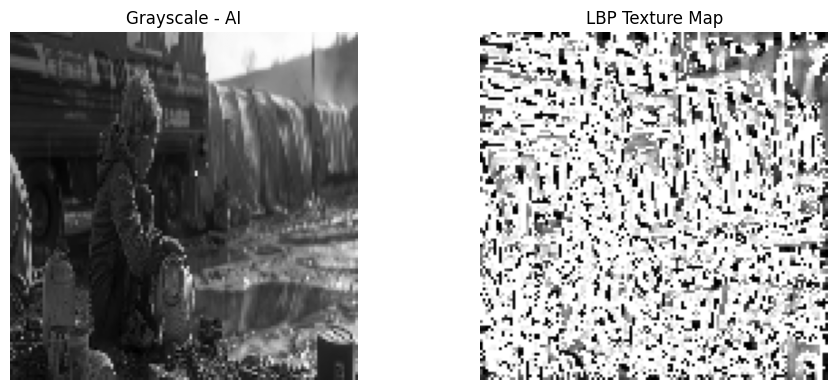

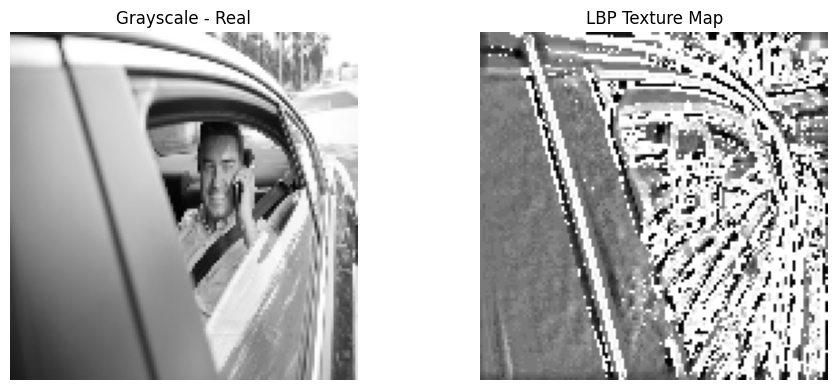


VEKTOR FITUR LBP UNTUK SETIAP KELAS (NORMALIZED HISTOGRAM)

--- Kelas: AI ---
Panjang Vektor: 26
Vektor Fitur Numerik:
[0.05755615 0.0368042  0.02307129 0.01538086 0.0100708  0.00897217
 0.01019287 0.00921631 0.00939941 0.01104736 0.01141357 0.01647949
 0.01873779 0.02026367 0.01501465 0.01263428 0.0112915  0.0098877
 0.01098633 0.01092529 0.01348877 0.01654053 0.02313232 0.0355835
 0.05401611 0.52789307]

--- Kelas: REAL ---
Panjang Vektor: 26
Vektor Fitur Numerik:
[0.02923584 0.02355957 0.01635742 0.01281738 0.01031494 0.00982666
 0.00860596 0.01190186 0.01330566 0.0211792  0.03106689 0.10211182
 0.15985107 0.08203125 0.02984619 0.01678467 0.01062012 0.01025391
 0.00726318 0.00653076 0.00915527 0.00958252 0.00946045 0.01916504
 0.03497314 0.30419922]


In [9]:
# 1. Fungsi Ekstraksi LBP
def extract_lbp_features(images, radius=3):
    """
    Ekstraksi histogram LBP dari list citra grayscale
    """
    n_points = 8 * radius
    method = 'uniform'
    features = []

    for img in images:
        # Jika gambar masih dalam skala 0-1 (float), kembalikan ke 0-255 untuk LBP
        if img.dtype == np.float32:
            img = (img * 255).astype("uint8")

        # Ekstraksi pola LBP
        lbp = local_binary_pattern(img, n_points, radius, method)

        # Hitung histogram pola (Vektor Fitur)
        # Untuk method='uniform', jumlah bin adalah n_points + 2
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))

        # Normalisasi histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        features.append(hist)

    return np.array(features)

# 2. Fungsi Visualisasi LBP
def show_lbp_example(image_gray, label_name, radius=3):
    n_points = 8 * radius
    # Pastikan tipe data benar
    if image_gray.dtype == np.float32:
        image_gray = (image_gray * 255).astype("uint8")

    lbp_image = local_binary_pattern(image_gray, n_points, radius, method='uniform')

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(image_gray, cmap='gray')
    axs[0].set_title(f"Grayscale - {label_name}")
    axs[1].imshow(lbp_image, cmap='gray') # Magma memudahkan melihat tekstur
    axs[1].set_title("LBP Texture Map")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    # 3. Ekstraksi LBP untuk Data Training dan Testing
print("Ekstraksi LBP untuk Data Training...")
X_train_lbp = extract_lbp_features(X_train_gray)

print("Ekstraksi LBP untuk Data Testing...")
X_test_lbp = extract_lbp_features(X_test_gray)

print("\n--- Hasil Ekstraksi LBP ---")
print(f"Bentuk Fitur LBP Training : {X_train_lbp.shape}") # Dimensi: (jumlah_data, 26)
print(f"Bentuk Fitur LBP Testing  : {X_test_lbp.shape}")

# 4. Tampilkan Visualisasi
idx_ai = y_train_new.index(0)
idx_real = y_train_new.index(1)

show_lbp_example(X_train_gray[idx_ai], "AI")
show_lbp_example(X_train_gray[idx_real], "Real")


# 3. Tampilkan Vektor Fitur Numerik (Disesuaikan dengan variabel baru)
print("\n" + "="*50)
print("VEKTOR FITUR LBP UNTUK SETIAP KELAS (NORMALIZED HISTOGRAM)")
print("="*50)

# Nama kelas sesuai label: 0 untuk AI, 1 untuk Real
class_names_list = ["AI", "Real"]

for i, class_name in enumerate(class_names_list):
    # Cari indeks pertama untuk label i dalam y_train_new
    idx = y_train_new.index(i)

    vector_to_show = X_train_lbp[idx]

    print(f"\n--- Kelas: {class_name.upper()} ---")
    print(f"Panjang Vektor: {len(vector_to_show)}")
    print("Vektor Fitur Numerik:")
    print(vector_to_show)

Kombinasi Fitur

In [10]:
print("Mempersiapkan semua kombinasi fitur (TRAIN & TEST)...")

# ===============================
# SKENARIO FITUR TUNGGAL
# ===============================

X_train_sc_color = X_train_color
X_test_sc_color  = X_test_color

X_train_sc_hog = X_train_hog
X_test_sc_hog  = X_test_hog

X_train_sc_lbp = X_train_lbp
X_test_sc_lbp  = X_test_lbp


# ===============================
# SKENARIO FEATURE FUSION
# ===============================

X_train_color_hog = np.hstack((X_train_color, X_train_hog))
X_test_color_hog  = np.hstack((X_test_color, X_test_hog))

X_train_color_lbp = np.hstack((X_train_color, X_train_lbp))
X_test_color_lbp  = np.hstack((X_test_color, X_test_lbp))

X_train_hog_lbp = np.hstack((X_train_hog, X_train_lbp))
X_test_hog_lbp  = np.hstack((X_test_hog, X_test_lbp))

X_train_all = np.hstack((X_train_color, X_train_hog, X_train_lbp))
X_test_all  = np.hstack((X_test_color, X_test_hog, X_test_lbp))

print("Persiapan selesai.")

feature_sets = {
    "Histogram Warna": (X_train_sc_color, X_test_sc_color),
    "HOG": (X_train_sc_hog, X_test_sc_hog),
    "LBP": (X_train_sc_lbp, X_test_sc_lbp),
    "Warna + HOG": (X_train_color_hog, X_test_color_hog),
    "Warna + LBP": (X_train_color_lbp, X_test_color_lbp),
    "HOG + LBP": (X_train_hog_lbp, X_test_hog_lbp),
    "Warna + HOG + LBP": (X_train_all, X_test_all)
}

print("\n" + "="*60)
print("       RINCIAN JUMLAH FITUR PER SKENARIO")
print("="*60)

for name, (Xtr, Xte) in feature_sets.items():
    print(f"- {name:<22}: {Xtr.shape[1]} fitur")


Mempersiapkan semua kombinasi fitur (TRAIN & TEST)...
Persiapan selesai.

       RINCIAN JUMLAH FITUR PER SKENARIO
- Histogram Warna       : 96 fitur
- HOG                   : 8100 fitur
- LBP                   : 26 fitur
- Warna + HOG           : 8196 fitur
- Warna + LBP           : 122 fitur
- HOG + LBP             : 8126 fitur
- Warna + HOG + LBP     : 8222 fitur


Training dan Evaluasi


   TRAINING & EVALUASI - FITUR: HISTOGRAM WARNA

Akurasi: 80.00%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.76      0.89      0.82        80
        Real       0.86      0.71      0.78        80

    accuracy                           0.80       160
   macro avg       0.81      0.80      0.80       160
weighted avg       0.81      0.80      0.80       160



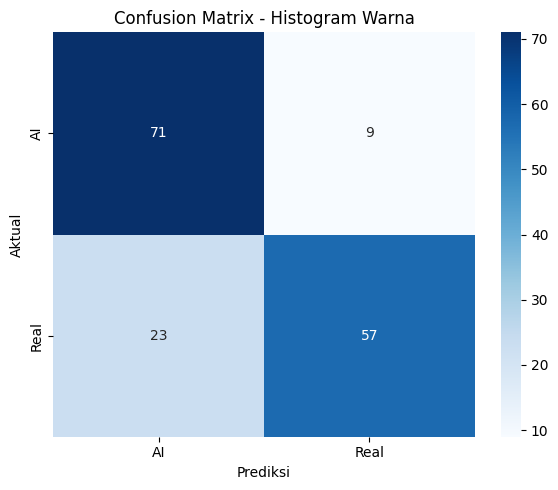


   TRAINING & EVALUASI - FITUR: HOG

Akurasi: 60.62%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.61      0.59      0.60        80
        Real       0.60      0.62      0.61        80

    accuracy                           0.61       160
   macro avg       0.61      0.61      0.61       160
weighted avg       0.61      0.61      0.61       160



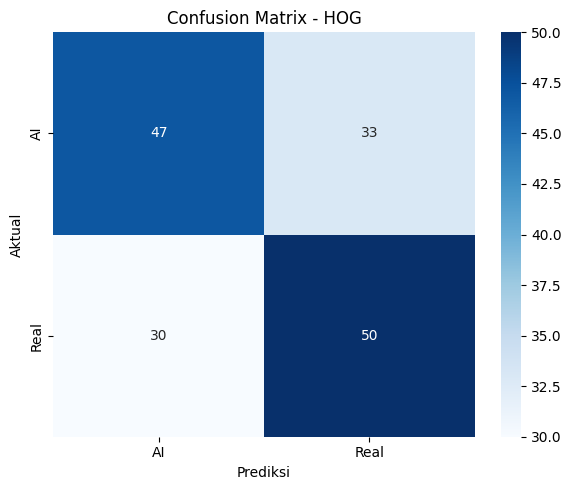


   TRAINING & EVALUASI - FITUR: LBP

Akurasi: 71.25%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.72      0.70      0.71        80
        Real       0.71      0.72      0.72        80

    accuracy                           0.71       160
   macro avg       0.71      0.71      0.71       160
weighted avg       0.71      0.71      0.71       160



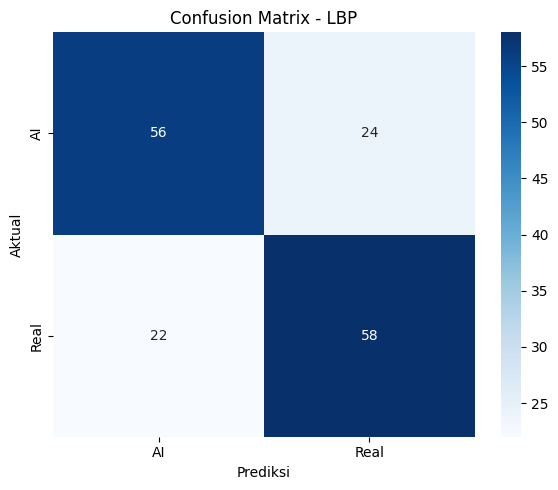


   TRAINING & EVALUASI - FITUR: WARNA + HOG

Akurasi: 76.25%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.76      0.76      0.76        80
        Real       0.76      0.76      0.76        80

    accuracy                           0.76       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.76      0.76      0.76       160



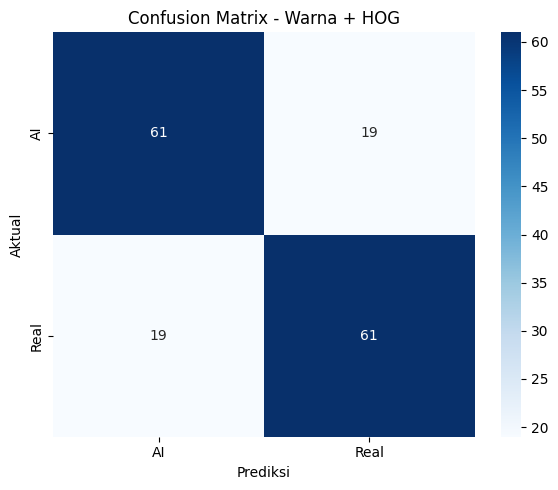


   TRAINING & EVALUASI - FITUR: WARNA + LBP

Akurasi: 80.00%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.78      0.84      0.81        80
        Real       0.82      0.76      0.79        80

    accuracy                           0.80       160
   macro avg       0.80      0.80      0.80       160
weighted avg       0.80      0.80      0.80       160



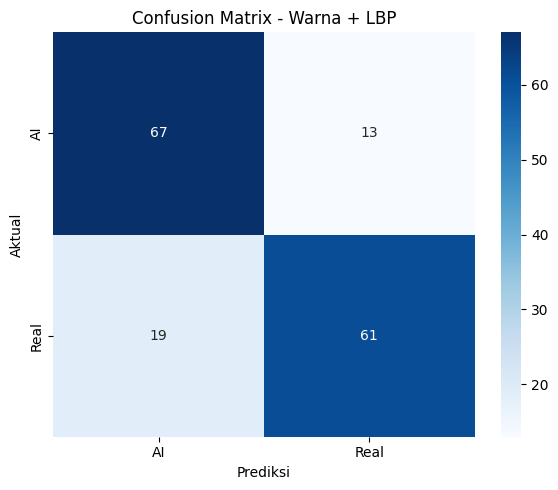


   TRAINING & EVALUASI - FITUR: HOG + LBP

Akurasi: 63.75%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.64      0.61      0.63        80
        Real       0.63      0.66      0.65        80

    accuracy                           0.64       160
   macro avg       0.64      0.64      0.64       160
weighted avg       0.64      0.64      0.64       160



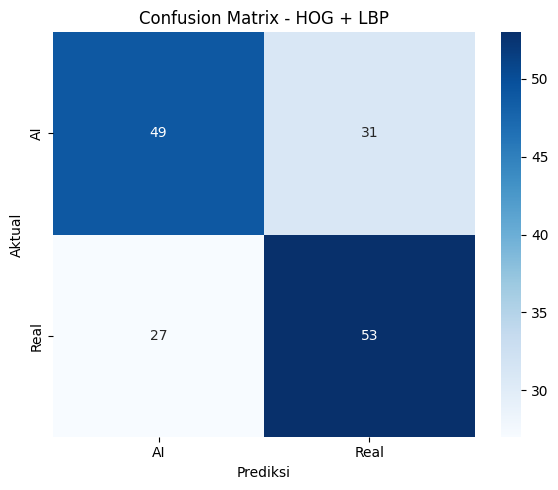


   TRAINING & EVALUASI - FITUR: WARNA + HOG + LBP

Akurasi: 79.38%

Laporan Klasifikasi:
              precision    recall  f1-score   support

          AI       0.78      0.82      0.80        80
        Real       0.81      0.76      0.79        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160



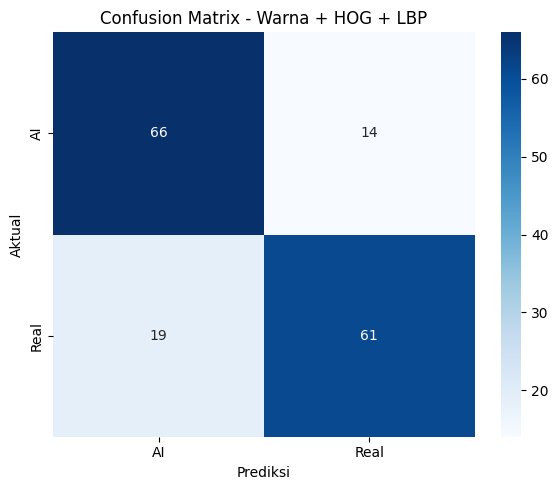

In [11]:
results = {}

for name, (X_train, X_test) in feature_sets.items():

    print("\n" + "="*60)
    print(f"   TRAINING & EVALUASI - FITUR: {name.upper()}")
    print("="*60)

    # ===============================
    # PIPELINE: SCALER + SVM
    # ===============================
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,
            random_state=42
        ))
    ])

    # ===============================
    # TRAINING (HANYA DATA TRAIN)
    # ===============================
    pipeline.fit(X_train, y_train_new)

    # ===============================
    # PREDIKSI DATA TEST
    # ===============================
    y_pred = pipeline.predict(X_test)

    # ===============================
    # EVALUASI
    # ===============================
    accuracy = accuracy_score(y_test_new, y_pred)
    results[name] = accuracy

    print(f"\nAkurasi: {accuracy * 100:.2f}%\n")

    print("Laporan Klasifikasi:")
    print(classification_report(
        y_test_new,
        y_pred,
        target_names=["AI", "Real"]
    ))

    # ===============================
    # CONFUSION MATRIX
    # ===============================
    cm = confusion_matrix(y_test_new, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=["AI", "Real"],
        yticklabels=["AI", "Real"]
    )
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()



       RINGKASAN PERBANDINGAN AKURASI AKHIR
Fitur: HOG                  | Akurasi: 60.62%
Fitur: HOG + LBP            | Akurasi: 63.75%
Fitur: LBP                  | Akurasi: 71.25%
Fitur: Warna + HOG          | Akurasi: 76.25%
Fitur: Warna + HOG + LBP    | Akurasi: 79.38%
Fitur: Histogram Warna      | Akurasi: 80.00%
Fitur: Warna + LBP          | Akurasi: 80.00%


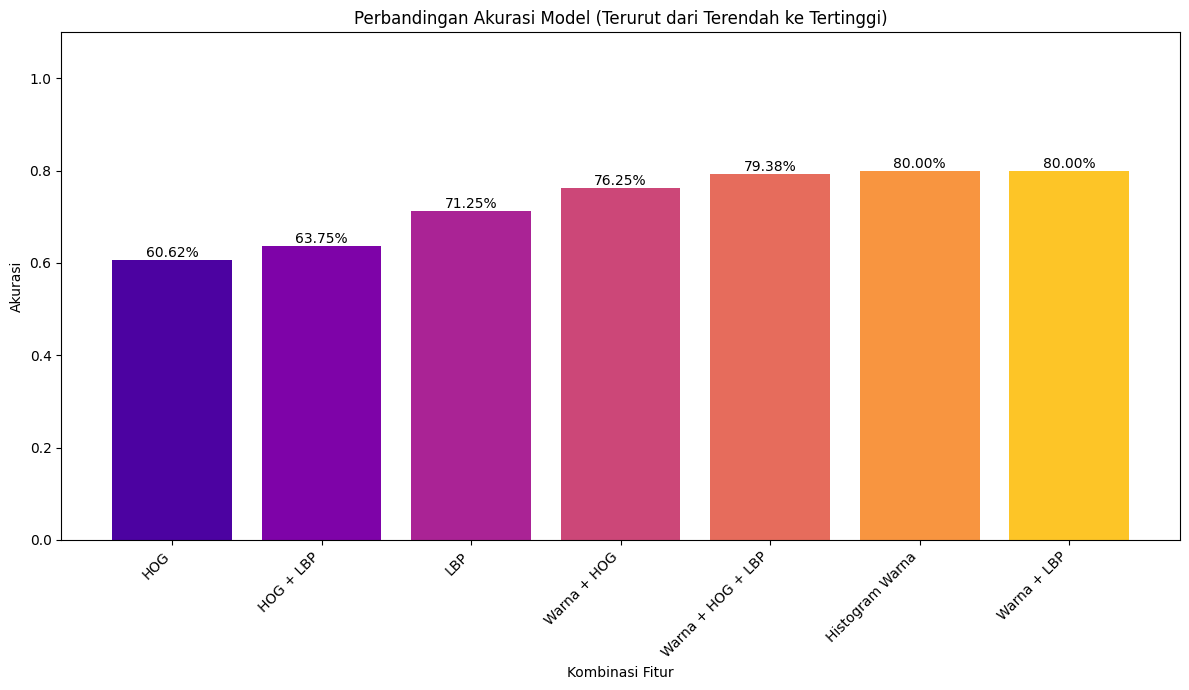

In [12]:
# RINGKASAN HASIL AKHIR

# ---  Mengurutkan hasil dari terkecil ke terbesar ---
sorted_results_asc = sorted(results.items(), key=lambda item: item[1])

print("\n" + "="*60)
print("       RINGKASAN PERBANDINGAN AKURASI AKHIR")
print("="*60)

for name, acc in sorted_results_asc:
    print(f"Fitur: {name:<20} | Akurasi: {acc * 100:.2f}%")

# --- Menyiapkan data untuk grafik yang terurut ---
sorted_names = [item[0] for item in sorted_results_asc]
sorted_accuracies = [item[1] for item in sorted_results_asc]

# Membuat plot batang untuk perbandingan visual
plt.figure(figsize=(12, 7))
barplot = plt.bar(sorted_names, sorted_accuracies, color=sns.color_palette("plasma", len(sorted_names)))

for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval * 100:.2f}%', va='bottom', ha='center')

plt.xlabel("Kombinasi Fitur")
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi Model (Terurut dari Terendah ke Tertinggi)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

Hypertuning

In [19]:
from sklearn.model_selection import GridSearchCV

# 1. Definisikan Set Fitur yang akan di-tuning
# Sesuaikan nama variabel dengan yang ada di kode kamu
best_feature_sets = {
    "Histogram Warna": (X_train_color, X_test_color),
    "Warna + LBP": (X_train_color_lbp, X_test_color_lbp)
}

# 2. Pipeline tetap sama (Scaler + SVM)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# 3. Grid Parameter yang lebih efisien
param_grid = {
    'svm__kernel': ['rbf', 'poly'],      # Menambah poly karena bagus untuk warna
    'svm__C': [0.1, 1, 10, 100],         # Regularisasi
    'svm__gamma': ['scale', 'auto'],     # Parameter jangkauan pengaruh data
    'svm__degree': [3]                   # Hanya dipakai jika kernel='poly'
}

tuning_results = {}

for name, (X_train_data, X_test_data) in best_feature_sets.items():
    print(f"\n>>> Memulai Tuning untuk Fitur: {name} <<<")

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train_data, y_train_new)

    # --- BAGIAN BARU: MENAMPILKAN TABEL HASIL ---
    print(f"\nLaporan Detail GridSearch - {name}:")

    # Ambil hasil CV ke dalam DataFrame
    results_df = pd.DataFrame(grid.cv_results_)

    # Pilih kolom-kolom yang kamu inginkan saja
    # Catatan: Kita filter untuk kernel 'rbf' saja agar sesuai format permintaanmu
    relevant_columns = [
        'param_svm__C',
        'param_svm__gamma',
        'mean_test_score',
        'std_test_score'
    ]

    # Mempercantik tampilan tabel
    display_df = results_df[relevant_columns].copy()
    display_df.columns = ['C', 'Gamma', 'Mean Akurasi CV', 'Standar Deviasi']

    # Urutkan berdasarkan Akurasi tertinggi
    display_df = display_df.sort_values(by='Mean Akurasi CV', ascending=False)

    # Tampilkan tabel (menggunakan print atau display jika di Colab)
    print(display_df.to_string(index=False))
    # --------------------------------------------

    # Ambil model terbaik untuk evaluasi akhir
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_data)
    acc = accuracy_score(y_test_new, y_pred)

    print(f"\nHasil Terbaik {name}: {grid.best_params_}")
    print(f"Akurasi Akhir Test Set: {acc*100:.2f}%")


>>> Memulai Tuning untuk Fitur: Histogram Warna <<<
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Laporan Detail GridSearch - Histogram Warna:
    C Gamma  Mean Akurasi CV  Standar Deviasi
  1.0  auto         0.778125         0.029195
  1.0 scale         0.778125         0.029195
  0.1 scale         0.758594         0.016783
  0.1  auto         0.758594         0.016783
 10.0  auto         0.758203         0.021014
 10.0 scale         0.758203         0.021014
  1.0 scale         0.737500         0.029090
  1.0  auto         0.737500         0.029090
 10.0 scale         0.736328         0.042108
 10.0  auto         0.736328         0.042108
100.0 scale         0.733984         0.026332
100.0  auto         0.733984         0.026332
  0.1 scale         0.712500         0.033453
  0.1  auto         0.712500         0.033453
100.0 scale         0.704688         0.044886
100.0  auto         0.704297         0.044822

Hasil Terbaik Histogram Warna: {'svm__C': 1, 'svm__degree

In [28]:
# 1. Gabungkan data Train dan Test (Secara Vertikal)
# Gunakan fitur terbaik kamu (Warna + LBP)
X_final = np.vstack((X_train_color_lbp, X_test_color_lbp))
y_final = np.hstack((y_train_new, y_test_new)) # Label digabung jadi satu list panjang

print(f"Total data untuk final training: {X_final.shape[0]} sampel")

# 2. Inisialisasi Pipeline dengan parameter terbaik hasil tuning kemarin
# Kemarin hasil terbaik adalah C=1, kernel='rbf'
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=1,
        probability=True,
        random_state=42
    ))
])

# 3. Training menggunakan SELURUH data
final_pipeline.fit(X_final, y_final)
print("Model final telah dilatih dengan seluruh dataset!")

# 4. Simpan model
model_filename = "svm_ai_vs_real_model.sav"
with open(model_filename, "wb") as file:
    pickle.dump(final_pipeline, file)

print(f"Model berhasil disimpan sebagai: {model_filename}")

Total data untuk final training: 2720 sampel
Model final telah dilatih dengan seluruh dataset!
Model berhasil disimpan sebagai: svm_ai_vs_real_model.sav


In [29]:
def predict_single_image(image_path, model_pipeline):
    # 1. Load Gambar
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Gambar tidak ditemukan")
        return None, None, None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Preprocessing (Resize ke 128 sesuai training terakhir)
    resized_rgb = cv2.resize(img_rgb, (128, 128))

    # --- BAGIAN PERBAIKAN ---
    # Konversi ke Grayscale KHUSUS untuk LBP
    resized_gray = cv2.cvtColor(resized_rgb, cv2.COLOR_RGB2GRAY)
    # -------------------------

    # 3. Ekstraksi Fitur
    # Warna tetap pakai yang RGB (3 channel)
    color_feat = extract_rgb_histogram([resized_rgb])[0]

    # LBP WAJIB pakai yang Grayscale (2 dimensi)
    lbp_feat = extract_lbp_features([resized_gray])[0]

    # 4. Gabungkan Fitur (Fusion)
    combined_features = np.hstack((color_feat, lbp_feat))

    # 5. Reshape untuk 1 sampel
    final_features = combined_features.reshape(1, -1)

    # 6. Prediksi
    prediction_code = model_pipeline.predict(final_features)

    # AI=0, Real=1 (sesuaikan dengan label training kamu)
    label_map = {0: "AI", 1: "Real"}
    prediction_name = label_map[prediction_code[0]]

    # 7. Confidence Score
    proba = model_pipeline.predict_proba(final_features)
    confidence = np.max(proba) * 100

    return img_rgb, prediction_name, confidence

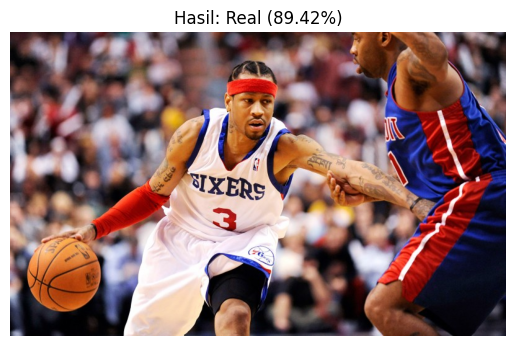

In [30]:
# Mencoba Gambar Baru
path_tes = "gambar_baru2.jpg"
original, hasil, skor = predict_single_image(path_tes, final_pipeline)

if original is not None:
    plt.imshow(original)
    plt.title(f"Hasil: {hasil} ({skor:.2f}%)")
    plt.axis('off')
    plt.show()